## Stochastic validations

We'd like to score the teams based on 100 realizations of their models — most of which are stochastic and take a random seed parameter. Please see the notebooks with `_VALIDATION` suffixes to see how the realizations we generated. Each one of those notebooks generartes a file called `<team>_100_realizations.npy`, which is what we are consuming here.

This notebook is super hacky I'm afraid.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, f1_score
from utils import accuracy, accuracy_adjacent, display_cm, facies_labels

Using globals. I am a miserable person.

In [2]:
PRED = pd.read_csv('prediction_depths.csv')
PRED.set_index(["Well Name", "Depth"], inplace=True)
PRED.head()

Unnamed: 0
Well Name Depth             
STUART    2808.0           0
          2808.5           1
          2809.0           2
          2809.5           3
          2810.0           4

In [3]:
TRUE = pd.read_csv('blind_stuart_crawford_core_facies.csv')
TRUE.rename(columns={'Depth.ft': 'Depth'}, inplace=True)
TRUE.rename(columns={'WellName': 'Well Name'}, inplace=True)
TRUE.set_index(["Well Name", "Depth"], inplace=True)
TRUE.head()

LithCode     LithLabel
Well Name Depth                         
STUART    2807.5         3  NM Shly Silt
          2808.0         3  NM Shly Silt
          2808.5         3  NM Shly Silt
          2809.0         3  NM Shly Silt
          2809.5         3  NM Shly Silt

In [4]:
def get_accuracies(y_preds):
    """
    Get the F1 scores from all the y_preds.
    y_blind is a 1D array. y_preds is a 2D array.
    """
    accs = []
    for y_pred in y_preds:
        PRED['Facies'] = y_pred
        all_data = PRED.join(TRUE, how='inner')
        y_blind = all_data['LithCode'].values
        y_pred = all_data['Facies'].values
        y_pred = y_pred[y_blind!=11]
        y_blind = y_blind[y_blind!=11]
        cv_conf = confusion_matrix(y_blind, y_pred)
        accs.append(accuracy(cv_conf))
    return np.array(accs)

LA-Team             0.6388
PA-Team             0.6250
ispl                0.6231
esaTeam             0.6225
SHandPR             0.6200
HouMath             0.6188


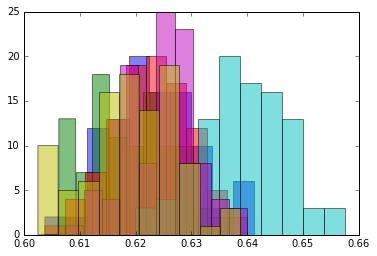

In [5]:
from glob import glob
from os import path
import operator

scores, medians = {}, {}
for f in glob('./*/*_100_realizations.npy'):
    team = path.basename(f).split('_')[0]
    y_preds = np.load(f)
    scores[team] = get_accuracies(y_preds)
    medians[team] = np.median(scores[team])
    plt.hist(pd.Series(scores[team]), alpha=0.5)
    
for t, m in sorted(medians.items(), key=operator.itemgetter(1), reverse=True):
    print("{:20s}{:.4f}".format(t, m))

## Look more closely at LA Team

(array([  3.,   4.,   8.,  13.,  20.,  17.,  16.,  13.,   3.,   3.]),
 array([ 0.62   ,  0.62375,  0.6275 ,  0.63125,  0.635  ,  0.63875,
         0.6425 ,  0.64625,  0.65   ,  0.65375,  0.6575 ]),
 <a list of 10 Patch objects>)

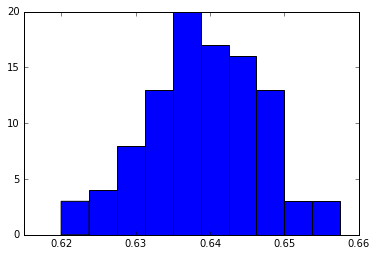

In [6]:
s = pd.Series(scores['LA-Team'])
plt.hist(s)

In [7]:
s.describe()

count    100.000000
mean       0.638575
std        0.007777
min        0.620000
25%        0.633750
50%        0.638750
75%        0.645000
max        0.657500
dtype: float64